# DTM Plane

In [67]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import choice
from scipy import signal
from pickle import load,dump
import math
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from math import atan, degrees
from scipy.signal import resample

In [68]:
def resample_series(data,sr_origin,sr_new):
    """
    Upsamples Series Vector to required Freq(Hz)
    data - Series 1D Array
    sr_origin - Origin Sampling Rate
    sr_new - New Sampling Rate
    Return - Resampled Data to Given Sample Rate
    """
    data = np.array(data)
    ln = data.shape[0]
    new_ln = int(ln*(sr_new/sr_origin))
    resampled_array = resample(data,new_ln)    
    return np.array(resampled_array)

- https://www.youtube.com/watch?v=EsM305FEZLk
- https://www.youtube.com/watch?v=N-qUfr-rz_Y
- https://geometry3d.readthedocs.io/en/latest/Geometry3D.calc.html#module-Geometry3D.calc.intersection
- https://keisan.casio.com/exec/system/1223596129

## Analysis

<AxesSubplot:title={'center':'Subjects/Varun/computed_Cup02.csv'}>

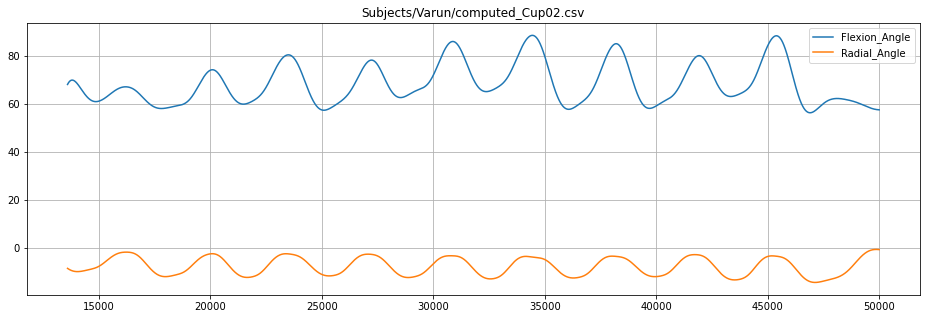

In [80]:
file = 'Subjects/Varun/computed_Cup02.csv'
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
angle_lables = ['Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle']
df = pd.read_csv(file,index_col=0)[12000:50000]
# Smoothen
for angle in angle_lables: df[angle] = filter_array(df[angle].values,order=4,cf=1,fs=2000)
    
df[1600:][angle_lables[1:3]].plot(figsize=(16,5),title=file,grid=True)

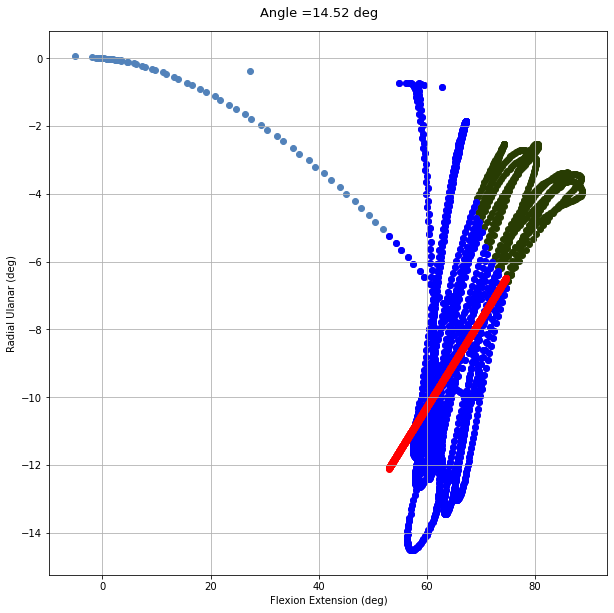

In [82]:
flexex_angle = df['Flexion_Angle']
radial_angle = df['Radial_Angle']

flexex_angle = np.array(flexex_angle).reshape((flexex_angle.shape[0],1))
radial_angle = np.array(radial_angle).reshape((flexex_angle.shape[0],1))

flexex_angle = resample_series(flexex_angle,sr_origin=2000,sr_new=100)
radial_angle = resample_series(radial_angle,sr_origin=2000,sr_new=100)


stack_angle = np.hstack((flexex_angle,radial_angle))

def clusterer(X,n_clusters=2):
#     k_pred = SpectralClustering(n_clusters=n_clusters).fit_predict(X)
    k_pred = GaussianMixture(n_components=n_clusters).fit_predict(X)
    clusters_list = []
    for i in range(n_clusters):
        data = []
        for j in range(len(k_pred)):
            if k_pred[j] == i:
                data.append(X[j])
        clusters_list.append(data)
    return clusters_list

        
clusters = clusterer(stack_angle,n_clusters = 3)
        
main_angles =np.array(clusters[0])
for i in range(1,len(clusters)):
    if len(main_angles) < len(clusters[i]):
        main_angles = np.array(clusters[i])

flexex_angle = main_angles[:,0].reshape(-1,1)
radial_angle = main_angles[:,1].reshape(-1,1)
regr = linear_model.LinearRegression()
regr.fit(flexex_angle,radial_angle.flatten())
radial_pred = regr.predict(flexex_angle)
slope = regr.coef_
intercept = regr.intercept_
angle = degrees(atan(slope))

plt.figure(figsize=(10,10))


for cluster in clusters:
    data = np.array(cluster)
    plt.scatter(data[:,0], data[:,1],c = np.random.rand(1, 3))

plt.scatter(flexex_angle, radial_angle,  color='blue')  

line_x = np.linspace(flexex_angle.min(),flexex_angle.max(),len(flexex_angle))
line_y = slope*line_x + intercept

# plt.scatter(flexex_angle, radial_pred, color='red')
plt.scatter(line_x, line_y, color='red')
plt.figtext(.5,.9,'Angle =' + str(np.round(angle,2))+' deg', fontsize=13, ha='center')

plt.grid()
plt.xlabel('Flexion Extension (deg)')
plt.ylabel('Radial Ulanar (deg)')
plt.show()

In [25]:
from statistics import variance

In [68]:
flexex_angle = df['Flexion_Angle']
radial_angle = df['Radial_Angle']
flexex_angle = np.array(flexex_angle).reshape((flexex_angle.shape[0],1))
radial_angle = np.array(radial_angle).reshape((flexex_angle.shape[0],1))
flexex_var = variance(flexex_angle.reshape((flexex_angle.shape[0],)))
radial_var = variance(radial_angle.reshape((radial_angle.shape[0],)))

In [69]:
dtm_var = 1/((1/flexex_var) + (1/radial_var))
dtm_angle = dtm_var*(flexex_angle*((1/flexex_var)) + radial_angle*((1/radial_var)))

In [70]:
df['DTM_Angle'] = dtm_angle

<AxesSubplot:>

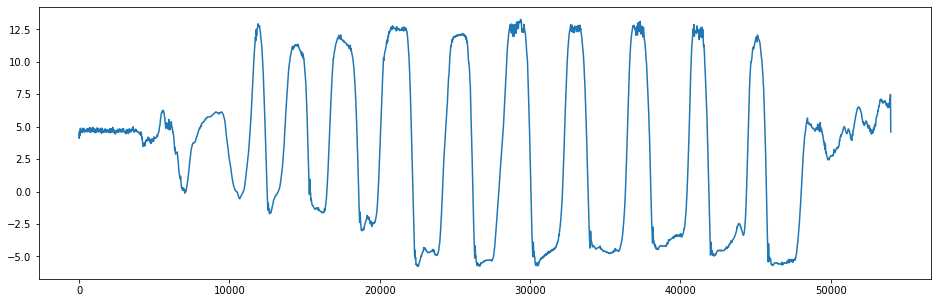

In [75]:
df['DTM_Angle'].plot(figsize=(16,5))

<AxesSubplot:>

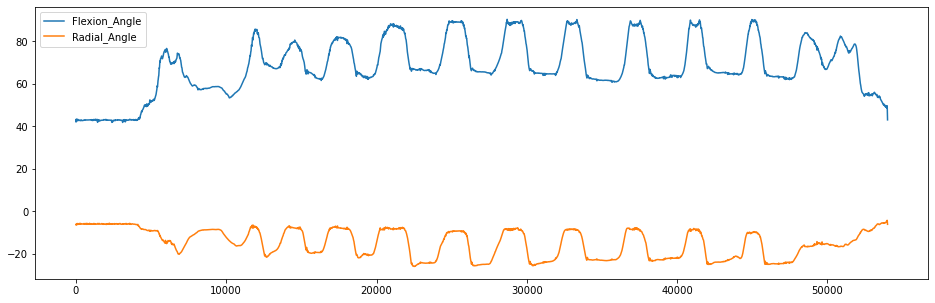

In [74]:
df[['Flexion_Angle','Radial_Angle']].plot(figsize=(16,5))